## Select the parameters for the experiment and log in the experiment folder

In [1]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 0  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['orh', 'sat-oat', 'wbt', 'flow']  # input predictors
x_loc = [0, 1, 2, 3]  # vars we want to plot in detailed plot
outputcols = ['cwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model_{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

# Smoothing
smooth_data = True  # whether to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['cwe', 'flow']  # create sum aggregate for these columns
rolling_mean_target = [
    'orh', 'sat-oat', 'wbt',
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

# Values below which we consider as 0 output in cwe units is kBTU in period*5 mins
threshold = 0.5

# Custom way to create Training Data
startweek = 0  # start week; indicates how large training set is
data_weeks = 39  # Create a large initial block startweek-data_weeks weeks of training and testing data
end_week = -1
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 8,
    'lstm_no_layers': 2,
    'dense_hidden_units': 16,
    'dense_no_layers': 4,
    'retrain_from_layers': 3,
    'train_stateful': False,
    'test_stateful':False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = True  # freeze weights of certain layers
reinitialize = True  # reinitialize the weights of certain layers

model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature',
        'hwe': 'Hot Water Energy Consumption',
        'cwe':'Cooling Energy',
        'wbt': 'Wet Builb Temperature',
        'flow':'Chilled Water Flow rate'
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

## Set Seed in numpy, Keras and TF for reproducability; Import modules; Set GPU configurations

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

## Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'normalplots')
os.mkdir(path + 'detailedplots')

## Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'startweek': startweek,
    'data_weeks' : data_weeks,
    'end_week':end_week,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

## Read the cleaned data

In [6]:
# read the pickled file for ahu data
df1data = dp.readfile(datapath)

# return pickled df
df1 = df1data.return_df(processmethods=['file2df'])

In [7]:
# read the pickled file for wet bulb data
df2data = dp.readfile('../data/processed/interpolated/wetbulbtemp.pkl')

# return pickled df
df2 = df2data.return_df(processmethods=['file2df'])

In [8]:
df = dp.merge_df_columns([df1,df2])

## Create additional Data columns as needed

In [9]:
df['sat-oat']= df['sat']-df['oat']

## Smooth the data

In [10]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

## Remove <0 values for output energy

In [11]:
df[outputcols[0]][df[outputcols[0]]<=0]=0.001

## Adjust lag for certain columns if needed

In [12]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

## Create aggregate data: aggregate specified columns at specified intervals

In [13]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    if rolling_sum_target:
        df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    if rolling_mean_target:
        df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

In [14]:
# show data
df.describe()

,oat,sat,sat_stpt,orh,hwe,cwe,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1,wbt,sat-oat
count,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,2.197100e+04,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000
mean,63.626268,70.279652,71.527172,60.052722,3.432717,1.379260e+02,172.949942,71.543912,224.198006,91.813681,8.736043,101.209883,101.228952,25.113443,55.037905,6.652519
std,17.451874,5.522785,2.912957,17.310180,4.176223,1.029794e+02,256.256255,1.049008,181.349203,13.201565,9.362448,14.165990,14.217190,19.756852,14.707197,17.865938
min,17.719488,51.414037,58.605072,17.309428,-1.593920,6.869853e-11,-52.457182,66.099812,-9.941482,64.903137,-2.463692,80.075723,87.778581,-6.725714,14.846887,-25.245728
25%,49.133815,67.350621,72.986150,46.642814,0.047487,4.085228e+01,-0.008301,70.895253,57.270068,82.487393,0.153497,90.170177,90.000000,8.603475,42.724135,-6.342551
50%,65.820118,71.940837,73.000000,59.389471,2.005893,1.280913e+02,14.551819,71.342909,195.659829,87.652988,5.768496,93.361023,91.824746,24.093105,57.820886,2.493411
75%,77.817693,73.671614,73.000000,74.189350,4.866380,2.305825e+02,284.159439,72.485714,381.397426,98.307198,13.121573,112.266250,112.209060,42.577149,68.115798,23.150384
max,97.158479,90.015817,74.044062,95.007589,26.854717,3.999292e+02,973.479051,73.557921,751.666065,135.552460,32.572670,147.479417,148.331329,73.261725,85.891934,55.312001


## Get mean of the entire scaled data

In [15]:
# get the mean of the outputs for the entire data
dfscaled = ((df-df.min())/(df.max()-df.min()))
threshold_scaled = ((threshold-df.min()[outputcols[0]])/(df.max()[outputcols[0]]-df.min()[outputcols[0]]))
dfscaled = dfscaled[dfscaled[outputcols[0]]>=threshold_scaled]
dfmean = dfscaled.mean() 
mean_output = list(dfmean[outputcols])
mean_input = list(dfmean[inputcols])

## Create temporal chunks of data

In [16]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 76


## Custom way to create Training Data

In [17]:
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

In [18]:
from pandas import concat
import swifter


def quickmerge(listdf):
    return concat(listdf)


def df2operating_regions(df, column_names, thresholds):
    """
    Select from data frame the operating regions based on threshold
    """
    
    org_shape = df.shape[0]
    
    # select cells to be retained
    constraints = df.swifter.apply(
        lambda row: all([(cell > thresholds) for cell in row[column_names]]),
        axis=1)
    # Drop values set to be rejected
    df = df.drop(df.index[~constraints], axis = 0)
    
    print("Retaining {}% of the data".format(100*df.shape[0]/org_shape))
    
    return df

weeklist = []  # create list of training, testing arrays

In [19]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[startweek:data_weeks-1]
datablock_train = quickmerge(datablock_train_pre)
#Select from data frame the operating regions
datablock_train = df2operating_regions(datablock_train, outputcols, threshold)
"""
#divide into contiguous regions
datablock_train = dp.subsequencing(datablock_train, period=period)
#drop smaller blocks
datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
#merge them together
minibatch_train = quickmerge(datablock_train)
"""
minibatch_train = datablock_train

# select weeks=1 worth of data
datablock_test_pre = dflist[data_weeks-1]
#Select from data frame the operating regions
datablock_test = df2operating_regions(datablock_test_pre, outputcols, threshold)
"""
#divide into contiguous operating region
datablock_test = dp.subsequencing(datablock_test_pre, period=period)
#drop smaller blocks
datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
#merge them together
minibatch_test = quickmerge(datablock_test)
"""
minibatch_test = datablock_test


# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# year and week
yearno = minibatch_test.index[int(splitvalue/2)].year
weekno = minibatch_test.index[int(splitvalue/2)].week

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })



Retaining 92.588298251873% of the data



Retaining 100.0% of the data


In [20]:
for weekdata in dflist[data_weeks:end_week]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[datablock_test_pre]
    datablock_train = quickmerge(datablock_train_pre)
    #Select from data frame the operating regions
    datablock_train = df2operating_regions(datablock_train, outputcols, threshold)
    minibatch_train = datablock_train
    
    # select weeks=1 worth of data
    datablock_test_pre = weekdata
    #Select from data frame the operating regions
    datablock_test = df2operating_regions(datablock_test_pre, outputcols, threshold)
    minibatch_test = datablock_test
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index
    
    # year and week no
    weekno += 1
    weekno = weekno if weekno%53 != 0 else 1
    yearno = yearno if weekno!= 1 else yearno+1

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

print('Length of weeklist: {}'.format(len(weeklist)))


Retaining 92.5942429373496% of the data



Retaining 100.0% of the data



Retaining 92.58366800535475% of the data



Retaining 100.0% of the data



Retaining 92.57239899892743% of the data



Retaining 100.0% of the data



Retaining 92.58499152315517% of the data



Retaining 99.6742671009772% of the data



Retaining 92.72409269785746% of the data



Retaining 100.0% of the data



Retaining 92.56213123547292% of the data



Retaining 100.0% of the data



Retaining 92.48351251242208% of the data



Retaining 100.0% of the data



Retaining 92.34590616375345% of the data



Retaining 100.0% of the data



Retaining 92.33885819521178% of the data



Retaining 100.0% of the data



Retaining 92.32755440796754% of the data



Retaining 100.0% of the data



Retaining 92.31621721462874% of the data



Retaining 100.0% of the data



Retaining 92.31337767923134% of the data



Retaining 100.0% of the data



Retaining 92.33391688933935% of the data



Retaining 100.0% of the data



Retaining 92.39080670268291% of the data



Retaining 100.0% of the data



Retaining 92.43643680263399% of the data



Retaining 100.0% of the data



Retaining 92.45713243341847% of the data



Retaining 100.0% of the data



Retaining 92.88107961235396% of the data



Retaining 100.0% of the data



Retaining 93.1951577402788% of the data



Retaining 100.0% of the data



Retaining 93.71627183755602% of the data



Retaining 100.0% of the data



Retaining 93.90154968094804% of the data



Retaining 100.0% of the data



Retaining 94.6820076100743% of the data



Retaining 100.0% of the data



Retaining 94.83614697120159% of the data



Retaining 100.0% of the data



Retaining 95.38876404494383% of the data



Retaining 100.0% of the data



Retaining 95.55575426987392% of the data



Retaining 99.70149253731343% of the data



Retaining 95.72497328108301% of the data



Retaining 100.0% of the data



Retaining 97.12965431440504% of the data



Retaining 100.0% of the data



Retaining 97.80666843548245% of the data



Retaining 100.0% of the data



Retaining 98.31268125494331% of the data



Retaining 63.503649635036496% of the data



Retaining 97.88913525498891% of the data



Retaining 52.17391304347826% of the data



Retaining 97.58337792045657% of the data



Retaining 73.52941176470588% of the data



Retaining 97.96814936847886% of the data



Retaining 95.75757575757575% of the data



Retaining 97.85988659228096% of the data



Retaining 100.0% of the data



Retaining 98.81997804610319% of the data



Retaining 94.921875% of the data



Retaining 98.77464529205822% of the data



Retaining 100.0% of the data



Retaining 98.77811718966953% of the data



Retaining 60.78431372549019% of the data



Retaining 98.37475196069167% of the data



Retaining 98.02631578947368% of the data
Length of weeklist: 37


## Print size and shape of data to feed to the model for sanity checks

In [21]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-16
name: X_train, shape: (10381, 1, 4)
name: y_train, shape: (10381, 1, 1)
name: X_test, shape: (321, 1, 4)
name: y_test, shape: (321, 1, 1)
name: test_idx, shape: (321,)
name: Id, shape: Year-2019-Week-17
name: X_train, shape: (10390, 1, 4)
name: y_train, shape: (10390, 1, 1)
name: X_test, shape: (316, 1, 4)
name: y_test, shape: (316, 1, 1)
name: test_idx, shape: (316,)
name: Id, shape: Year-2019-Week-18
name: X_train, shape: (10374, 1, 4)
name: y_train, shape: (10374, 1, 1)
name: X_test, shape: (312, 1, 4)
name: y_test, shape: (312, 1, 1)
name: test_idx, shape: (312,)
name: Id, shape: Year-2019-Week-19
name: X_train, shape: (10357, 1, 4)
name: y_train, shape: (10357, 1, 1)
name: X_test, shape: (314, 1, 4)
name: y_test, shape: (314, 1, 1)
name: test_idx, shape: (314,)
name: Id, shape: Year-2019-Week-20
name: X_train, shape: (10376, 1, 4)
name: y_train, shape: (10376, 1, 1)
name: X_test, shape: (306, 1, 4)
name: y_test, shape: (306, 1, 1)
name: test_idx,

## Add weekly train test data to modelconfig dictionary for ease of training

In [22]:
modelconfig['weeklist'] = weeklist

##  Clear the Tensorflow graph from previous training

In [23]:
K.clear_session()

## Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][1]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.simple_LSTM_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()
# print(K.get_session())

# # nn_model.model.summary()0x7f8d2b89f048  0x7f8ba4767550>

# #Instantiate learner model
# nn_model2 = mp.simple_LSTM_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model2.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# print(K.get_session())

## Train the model

In [24]:
for weekno, BatchData in enumerate(tqdm(modelconfig['weeklist'])):
    
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']

    """Begin weekly training"""   
    K.clear_session()
    
    try:
        del nn_model
    except NameError:
        pass

    #Instantiate learner model
    nn_model = mp.regression_nn(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['train_stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile()   

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       X_test,
                                       y_test,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    try:
        del nn_model_pred
    except NameError:
        pass

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.regression_nn(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['test_stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               save_plot_loc=path+'normalplots/',
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=[addl['names_abreviation'][outputcols[0]]],
                                               output_mean = mean_output)

    # do a detailed plot instead
    pu.regression_plot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    outputdim_names=[addl['names_abreviation'][outputcols[0]]],
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/37 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10381 samples, validate on 321 samples


Epoch 1/5000
 - 3s - loss: 0.0416 - val_loss: 0.0181
Epoch 2/5000
 - 2s - loss: 0.0191 - val_loss: 0.0164
Epoch 3/5000
 - 2s - loss: 0.0164 - val_loss: 0.0120
Epoch 4/5000
 - 2s - loss: 0.0124 - val_loss: 0.0081
Epoch 5/5000
 - 2s - loss: 0.0096 - val_loss: 0.0061
Epoch 6/5000
 - 2s - loss: 0.0084 - val_loss: 0.0056
Epoch 7/5000
 - 2s - loss: 0.0081 - val_loss: 0.0056
Epoch 8/5000
 - 2s - loss: 0.0079 - val_loss: 0.0055
Epoch 9/5000
 - 2s - loss: 0.0078 - val_loss: 0.0055
Epoch 10/5000
 - 2s - loss: 0.0078 - val_loss: 0.0055
Epoch 11/5000
 - 2s - loss: 0.0081 - val_loss: 0.0107
Epoch 12/5000
 - 2s - loss: 0.0087 - val_loss: 0.0098
Epoch 13/5000
 - 2s - loss: 0.0084 - val_loss: 0.0095
Epoch 14/5000
 - 2s - loss: 0.0082 - val_loss: 0.0094
Epoch 15/5000
 - 2s - loss: 0.0096 - val_loss: 0.0080


  3%|▎         | 1/37 [00:41<24:38, 41.06s/it]

Train on 10390 samples, validate on 316 samples
Epoch 16/5000
 - 3s - loss: 0.0294 - val_loss: 0.0082
Epoch 17/5000
 - 2s - loss: 0.0078 - val_loss: 0.0077
Epoch 18/5000
 - 2s - loss: 0.0075 - val_loss: 0.0079
Epoch 19/5000
 - 2s - loss: 0.0074 - val_loss: 0.0079
Epoch 20/5000
 - 2s - loss: 0.0078 - val_loss: 0.0100
Epoch 21/5000
 - 2s - loss: 0.0080 - val_loss: 0.0096
Epoch 22/5000
 - 2s - loss: 0.0078 - val_loss: 0.0095


  5%|▌         | 2/37 [01:02<20:28, 35.11s/it]

Train on 10374 samples, validate on 312 samples
Epoch 23/5000
 - 3s - loss: 0.0077 - val_loss: 0.0097
Epoch 24/5000
 - 2s - loss: 0.0080 - val_loss: 0.0090
Epoch 25/5000
 - 2s - loss: 0.0078 - val_loss: 0.0086
Epoch 26/5000
 - 2s - loss: 0.0076 - val_loss: 0.0084
Epoch 27/5000
 - 2s - loss: 0.0076 - val_loss: 0.0084
Epoch 28/5000
 - 2s - loss: 0.0076 - val_loss: 0.0083
Epoch 29/5000
 - 2s - loss: 0.0075 - val_loss: 0.0083
Epoch 30/5000
 - 2s - loss: 0.0075 - val_loss: 0.0082
Epoch 31/5000
 - 2s - loss: 0.0075 - val_loss: 0.0081
Epoch 32/5000
 - 2s - loss: 0.0075 - val_loss: 0.0081
Epoch 33/5000
 - 2s - loss: 0.0080 - val_loss: 0.0102
Epoch 34/5000
 - 2s - loss: 0.0078 - val_loss: 0.0095
Epoch 35/5000
 - 2s - loss: 0.0077 - val_loss: 0.0092
Epoch 36/5000
 - 2s - loss: 0.0076 - val_loss: 0.0091


  8%|▊         | 3/37 [01:40<20:26, 36.07s/it]

Train on 10357 samples, validate on 314 samples
Epoch 37/5000
 - 3s - loss: 0.0077 - val_loss: 0.0057
Epoch 38/5000
 - 2s - loss: 0.0078 - val_loss: 0.0057
Epoch 39/5000
 - 2s - loss: 0.0078 - val_loss: 0.0059
Epoch 40/5000
 - 2s - loss: 0.0082 - val_loss: 0.0088
Epoch 41/5000
 - 2s - loss: 0.0079 - val_loss: 0.0077
Epoch 42/5000
 - 2s - loss: 0.0077 - val_loss: 0.0074


 11%|█         | 4/37 [01:59<17:05, 31.07s/it]

Train on 10376 samples, validate on 306 samples
Epoch 43/5000
 - 3s - loss: 0.0074 - val_loss: 0.0119
Epoch 44/5000
 - 2s - loss: 0.0076 - val_loss: 0.0115
Epoch 45/5000
 - 2s - loss: 0.0076 - val_loss: 0.0111
Epoch 46/5000
 - 2s - loss: 0.0076 - val_loss: 0.0109
Epoch 47/5000
 - 2s - loss: 0.0076 - val_loss: 0.0109
Epoch 48/5000
 - 2s - loss: 0.0075 - val_loss: 0.0108
Epoch 49/5000
 - 2s - loss: 0.0075 - val_loss: 0.0108
Epoch 50/5000
 - 2s - loss: 0.0078 - val_loss: 0.0108
Epoch 51/5000
 - 2s - loss: 0.0083 - val_loss: 0.0076
Epoch 52/5000
 - 2s - loss: 0.0078 - val_loss: 0.0075
Epoch 53/5000
 - 2s - loss: 0.0076 - val_loss: 0.0074
Epoch 54/5000
 - 2s - loss: 0.0076 - val_loss: 0.0074
Epoch 55/5000
 - 2s - loss: 0.0076 - val_loss: 0.0073
Epoch 56/5000
 - 2s - loss: 0.0075 - val_loss: 0.0073
Epoch 57/5000
 - 2s - loss: 0.0078 - val_loss: 0.0074
Epoch 58/5000
 - 2s - loss: 0.0076 - val_loss: 0.0075
Epoch 59/5000
 - 2s - loss: 0.0076 - val_loss: 0.0076
Epoch 60/5000
 - 2s - loss: 0.0075

 14%|█▎        | 5/37 [02:50<19:36, 36.77s/it]

Train on 10603 samples, validate on 87 samples
Epoch 62/5000
 - 3s - loss: 0.0071 - val_loss: 0.0024
Epoch 63/5000
 - 2s - loss: 0.0073 - val_loss: 0.0024
Epoch 64/5000
 - 2s - loss: 0.0074 - val_loss: 0.0025
Epoch 65/5000
 - 2s - loss: 0.0081 - val_loss: 0.0023
Epoch 66/5000
 - 2s - loss: 0.0077 - val_loss: 0.0023
Epoch 67/5000
 - 2s - loss: 0.0076 - val_loss: 0.0023
Epoch 68/5000
 - 2s - loss: 0.0075 - val_loss: 0.0023
Epoch 69/5000
 - 2s - loss: 0.0079 - val_loss: 0.0024
Epoch 70/5000
 - 2s - loss: 0.0076 - val_loss: 0.0026
Epoch 71/5000
 - 2s - loss: 0.0075 - val_loss: 0.0026
Epoch 72/5000
 - 2s - loss: 0.0075 - val_loss: 0.0026
Epoch 73/5000
 - 2s - loss: 0.0074 - val_loss: 0.0026


 16%|█▌        | 6/37 [03:23<18:27, 35.73s/it]

Train on 10354 samples, validate on 219 samples
Epoch 74/5000
 - 3s - loss: 0.0070 - val_loss: 0.0041
Epoch 75/5000
 - 2s - loss: 0.0073 - val_loss: 0.0028
Epoch 76/5000
 - 2s - loss: 0.0073 - val_loss: 0.0026
Epoch 77/5000
 - 2s - loss: 0.0073 - val_loss: 0.0025
Epoch 78/5000
 - 2s - loss: 0.0073 - val_loss: 0.0025
Epoch 79/5000
 - 2s - loss: 0.0079 - val_loss: 0.0025
Epoch 80/5000
 - 2s - loss: 0.0075 - val_loss: 0.0025
Epoch 81/5000
 - 2s - loss: 0.0074 - val_loss: 0.0025
Epoch 82/5000
 - 2s - loss: 0.0074 - val_loss: 0.0025
Epoch 83/5000
 - 2s - loss: 0.0077 - val_loss: 0.0026
Epoch 84/5000
 - 2s - loss: 0.0075 - val_loss: 0.0028
Epoch 85/5000
 - 2s - loss: 0.0074 - val_loss: 0.0029
Epoch 86/5000
 - 2s - loss: 0.0073 - val_loss: 0.0029
Epoch 87/5000
 - 2s - loss: 0.0073 - val_loss: 0.0029


 19%|█▉        | 7/37 [04:00<18:08, 36.28s/it]

Train on 10237 samples, validate on 137 samples
Epoch 88/5000
 - 3s - loss: 0.0074 - val_loss: 0.0056
Epoch 89/5000
 - 2s - loss: 0.0074 - val_loss: 0.0058
Epoch 90/5000
 - 2s - loss: 0.0074 - val_loss: 0.0059
Epoch 91/5000
 - 2s - loss: 0.0078 - val_loss: 0.0059
Epoch 92/5000
 - 2s - loss: 0.0075 - val_loss: 0.0059
Epoch 93/5000
 - 2s - loss: 0.0074 - val_loss: 0.0058


 22%|██▏       | 8/37 [04:19<14:55, 30.88s/it]

Train on 10038 samples, validate on 326 samples
Epoch 94/5000
 - 3s - loss: 0.0070 - val_loss: 0.0051
Epoch 95/5000
 - 2s - loss: 0.0070 - val_loss: 0.0052
Epoch 96/5000
 - 2s - loss: 0.0070 - val_loss: 0.0052
Epoch 97/5000
 - 2s - loss: 0.0075 - val_loss: 0.0053
Epoch 98/5000
 - 2s - loss: 0.0072 - val_loss: 0.0052
Epoch 99/5000
 - 2s - loss: 0.0072 - val_loss: 0.0051
Epoch 100/5000
 - 2s - loss: 0.0071 - val_loss: 0.0049
Epoch 101/5000
 - 2s - loss: 0.0071 - val_loss: 0.0049
Epoch 102/5000
 - 2s - loss: 0.0071 - val_loss: 0.0048
Epoch 103/5000
 - 2s - loss: 0.0076 - val_loss: 0.0053
Epoch 104/5000
 - 2s - loss: 0.0072 - val_loss: 0.0057
Epoch 105/5000
 - 2s - loss: 0.0071 - val_loss: 0.0059
Epoch 106/5000
 - 2s - loss: 0.0071 - val_loss: 0.0060
Epoch 107/5000
 - 2s - loss: 0.0071 - val_loss: 0.0060


 24%|██▍       | 9/37 [04:56<15:17, 32.77s/it]

Train on 10028 samples, validate on 318 samples
Epoch 108/5000
 - 3s - loss: 0.0067 - val_loss: 0.0063
Epoch 109/5000
 - 2s - loss: 0.0068 - val_loss: 0.0072
Epoch 110/5000
 - 2s - loss: 0.0068 - val_loss: 0.0070
Epoch 111/5000
 - 2s - loss: 0.0072 - val_loss: 0.0061
Epoch 112/5000
 - 2s - loss: 0.0068 - val_loss: 0.0061
Epoch 113/5000
 - 2s - loss: 0.0067 - val_loss: 0.0061
Epoch 114/5000
 - 2s - loss: 0.0067 - val_loss: 0.0060
Epoch 115/5000
 - 2s - loss: 0.0071 - val_loss: 0.0063
Epoch 116/5000
 - 2s - loss: 0.0069 - val_loss: 0.0066
Epoch 117/5000
 - 2s - loss: 0.0068 - val_loss: 0.0067
Epoch 118/5000
 - 2s - loss: 0.0067 - val_loss: 0.0067
Epoch 119/5000
 - 2s - loss: 0.0067 - val_loss: 0.0067


 27%|██▋       | 10/37 [05:28<14:41, 32.66s/it]

Train on 10012 samples, validate on 319 samples
Epoch 120/5000
 - 3s - loss: 0.0068 - val_loss: 0.0093
Epoch 121/5000
 - 2s - loss: 0.0067 - val_loss: 0.0098
Epoch 122/5000
 - 2s - loss: 0.0067 - val_loss: 0.0095
Epoch 123/5000
 - 2s - loss: 0.0071 - val_loss: 0.0092
Epoch 124/5000
 - 2s - loss: 0.0068 - val_loss: 0.0091
Epoch 125/5000
 - 2s - loss: 0.0067 - val_loss: 0.0089
Epoch 126/5000
 - 2s - loss: 0.0067 - val_loss: 0.0087
Epoch 127/5000
 - 2s - loss: 0.0067 - val_loss: 0.0085
Epoch 128/5000
 - 2s - loss: 0.0066 - val_loss: 0.0083
Epoch 129/5000
 - 2s - loss: 0.0066 - val_loss: 0.0083
Epoch 130/5000
 - 2s - loss: 0.0066 - val_loss: 0.0082
Epoch 131/5000
 - 2s - loss: 0.0066 - val_loss: 0.0082
Epoch 132/5000
 - 2s - loss: 0.0066 - val_loss: 0.0081
Epoch 133/5000
 - 2s - loss: 0.0071 - val_loss: 0.0091
Epoch 134/5000
 - 2s - loss: 0.0068 - val_loss: 0.0095
Epoch 135/5000
 - 2s - loss: 0.0067 - val_loss: 0.0097
Epoch 136/5000
 - 2s - loss: 0.0067 - val_loss: 0.0098
Epoch 137/5000
 -

 30%|██▉       | 11/37 [06:15<15:57, 36.82s/it]

Train on 9996 samples, validate on 327 samples
Epoch 138/5000
 - 3s - loss: 0.0060 - val_loss: 0.0029
Epoch 139/5000
 - 2s - loss: 0.0059 - val_loss: 0.0029
Epoch 140/5000
 - 2s - loss: 0.0059 - val_loss: 0.0029
Epoch 141/5000
 - 2s - loss: 0.0066 - val_loss: 0.0031
Epoch 142/5000
 - 2s - loss: 0.0062 - val_loss: 0.0031
Epoch 143/5000
 - 2s - loss: 0.0061 - val_loss: 0.0031


 32%|███▏      | 12/37 [06:33<13:04, 31.37s/it]

Train on 9992 samples, validate on 322 samples
Epoch 144/5000
 - 3s - loss: 0.0042 - val_loss: 0.0040
Epoch 145/5000
 - 2s - loss: 0.0041 - val_loss: 0.0040
Epoch 146/5000
 - 2s - loss: 0.0041 - val_loss: 0.0040
Epoch 147/5000
 - 2s - loss: 0.0047 - val_loss: 0.0042
Epoch 148/5000
 - 2s - loss: 0.0044 - val_loss: 0.0042
Epoch 149/5000
 - 2s - loss: 0.0043 - val_loss: 0.0042
Epoch 150/5000
 - 2s - loss: 0.0043 - val_loss: 0.0042


 35%|███▌      | 13/37 [06:54<11:18, 28.25s/it]

Train on 10021 samples, validate on 335 samples
Epoch 151/5000
 - 3s - loss: 0.0042 - val_loss: 0.0065
Epoch 152/5000
 - 2s - loss: 0.0043 - val_loss: 0.0066
Epoch 153/5000
 - 2s - loss: 0.0042 - val_loss: 0.0066
Epoch 154/5000
 - 2s - loss: 0.0051 - val_loss: 0.0055
Epoch 155/5000
 - 2s - loss: 0.0045 - val_loss: 0.0056
Epoch 156/5000
 - 2s - loss: 0.0044 - val_loss: 0.0056
Epoch 157/5000
 - 2s - loss: 0.0044 - val_loss: 0.0055
Epoch 158/5000
 - 2s - loss: 0.0048 - val_loss: 0.0052
Epoch 159/5000
 - 2s - loss: 0.0045 - val_loss: 0.0053
Epoch 160/5000
 - 2s - loss: 0.0044 - val_loss: 0.0054
Epoch 161/5000
 - 2s - loss: 0.0044 - val_loss: 0.0054
Epoch 162/5000
 - 2s - loss: 0.0044 - val_loss: 0.0054
Epoch 163/5000
 - 2s - loss: 0.0043 - val_loss: 0.0054


 38%|███▊      | 14/37 [07:29<11:33, 30.16s/it]

Train on 10090 samples, validate on 333 samples
Epoch 164/5000
 - 3s - loss: 0.0042 - val_loss: 0.0046
Epoch 165/5000
 - 2s - loss: 0.0042 - val_loss: 0.0049
Epoch 166/5000
 - 2s - loss: 0.0042 - val_loss: 0.0049
Epoch 167/5000
 - 2s - loss: 0.0046 - val_loss: 0.0062
Epoch 168/5000
 - 2s - loss: 0.0045 - val_loss: 0.0063
Epoch 169/5000
 - 2s - loss: 0.0044 - val_loss: 0.0063


 41%|████      | 15/37 [07:48<09:49, 26.78s/it]

Train on 10107 samples, validate on 332 samples
Epoch 170/5000
 - 3s - loss: 0.0043 - val_loss: 0.0052
Epoch 171/5000
 - 2s - loss: 0.0042 - val_loss: 0.0053
Epoch 172/5000
 - 2s - loss: 0.0042 - val_loss: 0.0052
Epoch 173/5000
 - 2s - loss: 0.0046 - val_loss: 0.0037
Epoch 174/5000
 - 2s - loss: 0.0044 - val_loss: 0.0037
Epoch 175/5000
 - 2s - loss: 0.0043 - val_loss: 0.0037
Epoch 176/5000
 - 2s - loss: 0.0043 - val_loss: 0.0037
Epoch 177/5000
 - 2s - loss: 0.0046 - val_loss: 0.0035
Epoch 178/5000
 - 2s - loss: 0.0044 - val_loss: 0.0035
Epoch 179/5000
 - 2s - loss: 0.0044 - val_loss: 0.0036
Epoch 180/5000
 - 2s - loss: 0.0043 - val_loss: 0.0036
Epoch 181/5000
 - 2s - loss: 0.0043 - val_loss: 0.0036
Epoch 182/5000
 - 2s - loss: 0.0043 - val_loss: 0.0036


 43%|████▎     | 16/37 [08:23<10:15, 29.31s/it]

Train on 10137 samples, validate on 336 samples
Epoch 183/5000
 - 3s - loss: 0.0042 - val_loss: 0.0022
Epoch 184/5000
 - 2s - loss: 0.0044 - val_loss: 0.0022
Epoch 185/5000
 - 2s - loss: 0.0043 - val_loss: 0.0022
Epoch 186/5000
 - 2s - loss: 0.0050 - val_loss: 0.0021
Epoch 187/5000
 - 2s - loss: 0.0043 - val_loss: 0.0021
Epoch 188/5000
 - 2s - loss: 0.0042 - val_loss: 0.0021
Epoch 189/5000
 - 2s - loss: 0.0042 - val_loss: 0.0021
Epoch 190/5000
 - 2s - loss: 0.0044 - val_loss: 0.0023
Epoch 191/5000
 - 2s - loss: 0.0043 - val_loss: 0.0024


 46%|████▌     | 17/37 [08:49<09:22, 28.15s/it]

Train on 10255 samples, validate on 150 samples
Epoch 192/5000
 - 3s - loss: 0.0042 - val_loss: 0.0016
Epoch 193/5000
 - 2s - loss: 0.0042 - val_loss: 0.0017
Epoch 194/5000
 - 2s - loss: 0.0042 - val_loss: 0.0017
Epoch 195/5000
 - 2s - loss: 0.0047 - val_loss: 0.0017
Epoch 196/5000
 - 2s - loss: 0.0043 - val_loss: 0.0018
Epoch 197/5000
 - 2s - loss: 0.0042 - val_loss: 0.0018


 49%|████▊     | 18/37 [09:07<08:01, 25.36s/it]

Train on 10162 samples, validate on 327 samples
Epoch 198/5000
 - 3s - loss: 0.0043 - val_loss: 0.0029
Epoch 199/5000
 - 2s - loss: 0.0042 - val_loss: 0.0029
Epoch 200/5000
 - 2s - loss: 0.0042 - val_loss: 0.0029
Epoch 201/5000
 - 2s - loss: 0.0047 - val_loss: 0.0029
Epoch 202/5000
 - 2s - loss: 0.0042 - val_loss: 0.0029
Epoch 203/5000
 - 2s - loss: 0.0042 - val_loss: 0.0029
Epoch 204/5000
 - 2s - loss: 0.0041 - val_loss: 0.0029
Epoch 205/5000
 - 2s - loss: 0.0043 - val_loss: 0.0029
Epoch 206/5000
 - 2s - loss: 0.0042 - val_loss: 0.0029


 51%|█████▏    | 19/37 [09:34<07:40, 25.59s/it]

Train on 10246 samples, validate on 336 samples
Epoch 207/5000
 - 3s - loss: 0.0041 - val_loss: 0.0052
Epoch 208/5000
 - 2s - loss: 0.0041 - val_loss: 0.0052
Epoch 209/5000
 - 2s - loss: 0.0042 - val_loss: 0.0052
Epoch 210/5000
 - 2s - loss: 0.0048 - val_loss: 0.0052
Epoch 211/5000
 - 2s - loss: 0.0042 - val_loss: 0.0052
Epoch 212/5000
 - 2s - loss: 0.0041 - val_loss: 0.0052
Epoch 213/5000
 - 2s - loss: 0.0041 - val_loss: 0.0052
Epoch 214/5000
 - 2s - loss: 0.0043 - val_loss: 0.0053


 54%|█████▍    | 20/37 [09:58<07:06, 25.11s/it]

Train on 10301 samples, validate on 336 samples
Epoch 215/5000
 - 3s - loss: 0.0044 - val_loss: 0.0077
Epoch 216/5000
 - 2s - loss: 0.0042 - val_loss: 0.0078
Epoch 217/5000
 - 2s - loss: 0.0042 - val_loss: 0.0078
Epoch 218/5000
 - 2s - loss: 0.0048 - val_loss: 0.0061
Epoch 219/5000
 - 2s - loss: 0.0042 - val_loss: 0.0061
Epoch 220/5000
 - 2s - loss: 0.0042 - val_loss: 0.0061
Epoch 221/5000
 - 2s - loss: 0.0041 - val_loss: 0.0061
Epoch 222/5000
 - 2s - loss: 0.0043 - val_loss: 0.0056
Epoch 223/5000
 - 2s - loss: 0.0042 - val_loss: 0.0055
Epoch 224/5000
 - 2s - loss: 0.0042 - val_loss: 0.0054
Epoch 225/5000
 - 2s - loss: 0.0041 - val_loss: 0.0054
Epoch 226/5000
 - 2s - loss: 0.0041 - val_loss: 0.0054
Epoch 227/5000
 - 2s - loss: 0.0041 - val_loss: 0.0054
Epoch 228/5000
 - 2s - loss: 0.0041 - val_loss: 0.0054
Epoch 229/5000
 - 2s - loss: 0.0041 - val_loss: 0.0053
Epoch 230/5000
 - 2s - loss: 0.0041 - val_loss: 0.0053
Epoch 231/5000
 - 2s - loss: 0.0041 - val_loss: 0.0053
Epoch 232/5000
 -

 57%|█████▋    | 21/37 [11:24<11:34, 43.40s/it]

Train on 10451 samples, validate on 336 samples
Epoch 250/5000
 - 3s - loss: 0.0043 - val_loss: 0.0129
Epoch 251/5000
 - 2s - loss: 0.0042 - val_loss: 0.0129
Epoch 252/5000
 - 2s - loss: 0.0042 - val_loss: 0.0129
Epoch 253/5000
 - 2s - loss: 0.0044 - val_loss: 0.0094
Epoch 254/5000
 - 2s - loss: 0.0043 - val_loss: 0.0093
Epoch 255/5000
 - 2s - loss: 0.0042 - val_loss: 0.0093
Epoch 256/5000
 - 2s - loss: 0.0041 - val_loss: 0.0093
Epoch 257/5000
 - 2s - loss: 0.0043 - val_loss: 0.0093
Epoch 258/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 259/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 260/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 261/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 262/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 263/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 264/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 265/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 266/5000
 - 2s - loss: 0.0042 - val_loss: 0.0092
Epoch 267/5000
 -

 59%|█████▉    | 22/37 [12:41<13:21, 53.44s/it]

Train on 10505 samples, validate on 325 samples
Epoch 280/5000
 - 3s - loss: 0.0045 - val_loss: 0.0070
Epoch 281/5000
 - 2s - loss: 0.0046 - val_loss: 0.0069
Epoch 282/5000
 - 2s - loss: 0.0047 - val_loss: 0.0068
Epoch 283/5000
 - 2s - loss: 0.0047 - val_loss: 0.0068
Epoch 284/5000
 - 2s - loss: 0.0047 - val_loss: 0.0068
Epoch 285/5000
 - 2s - loss: 0.0050 - val_loss: 0.0067
Epoch 286/5000
 - 2s - loss: 0.0045 - val_loss: 0.0067
Epoch 287/5000
 - 2s - loss: 0.0043 - val_loss: 0.0067
Epoch 288/5000
 - 2s - loss: 0.0043 - val_loss: 0.0067
Epoch 289/5000
 - 2s - loss: 0.0044 - val_loss: 0.0067
Epoch 290/5000
 - 2s - loss: 0.0044 - val_loss: 0.0066
Epoch 291/5000
 - 2s - loss: 0.0044 - val_loss: 0.0066
Epoch 292/5000
 - 2s - loss: 0.0043 - val_loss: 0.0065
Epoch 293/5000
 - 2s - loss: 0.0043 - val_loss: 0.0066
Epoch 294/5000
 - 2s - loss: 0.0043 - val_loss: 0.0066
Epoch 295/5000
 - 2s - loss: 0.0043 - val_loss: 0.0066
Epoch 296/5000
 - 2s - loss: 0.0043 - val_loss: 0.0066
Epoch 297/5000
 -

 62%|██████▏   | 23/37 [13:29<12:07, 51.98s/it]

Train on 10612 samples, validate on 336 samples
Epoch 298/5000
 - 3s - loss: 0.0046 - val_loss: 0.0146
Epoch 299/5000
 - 2s - loss: 0.0046 - val_loss: 0.0148
Epoch 300/5000
 - 2s - loss: 0.0046 - val_loss: 0.0148
Epoch 301/5000
 - 2s - loss: 0.0050 - val_loss: 0.0109
Epoch 302/5000
 - 2s - loss: 0.0044 - val_loss: 0.0108
Epoch 303/5000
 - 2s - loss: 0.0044 - val_loss: 0.0108
Epoch 304/5000
 - 2s - loss: 0.0043 - val_loss: 0.0108
Epoch 305/5000
 - 2s - loss: 0.0044 - val_loss: 0.0108
Epoch 306/5000
 - 2s - loss: 0.0044 - val_loss: 0.0108
Epoch 307/5000
 - 2s - loss: 0.0044 - val_loss: 0.0108
Epoch 308/5000
 - 2s - loss: 0.0043 - val_loss: 0.0108


 65%|██████▍   | 24/37 [14:00<09:52, 45.59s/it]

Train on 10686 samples, validate on 334 samples
Epoch 309/5000
 - 3s - loss: 0.0050 - val_loss: 0.0136
Epoch 310/5000
 - 2s - loss: 0.0049 - val_loss: 0.0135
Epoch 311/5000
 - 2s - loss: 0.0049 - val_loss: 0.0134
Epoch 312/5000
 - 2s - loss: 0.0049 - val_loss: 0.0133
Epoch 313/5000
 - 2s - loss: 0.0049 - val_loss: 0.0133
Epoch 314/5000
 - 2s - loss: 0.0049 - val_loss: 0.0132
Epoch 315/5000
 - 2s - loss: 0.0048 - val_loss: 0.0132
Epoch 316/5000
 - 2s - loss: 0.0048 - val_loss: 0.0131
Epoch 317/5000
 - 2s - loss: 0.0048 - val_loss: 0.0130
Epoch 318/5000
 - 2s - loss: 0.0048 - val_loss: 0.0129
Epoch 319/5000
 - 2s - loss: 0.0048 - val_loss: 0.0128
Epoch 320/5000
 - 2s - loss: 0.0048 - val_loss: 0.0127
Epoch 321/5000
 - 2s - loss: 0.0048 - val_loss: 0.0127
Epoch 322/5000
 - 2s - loss: 0.0048 - val_loss: 0.0126
Epoch 323/5000
 - 2s - loss: 0.0048 - val_loss: 0.0125
Epoch 324/5000
 - 2s - loss: 0.0048 - val_loss: 0.0124
Epoch 325/5000
 - 2s - loss: 0.0048 - val_loss: 0.0123
Epoch 326/5000
 -

 68%|██████▊   | 25/37 [16:03<13:47, 69.00s/it]

Train on 10748 samples, validate on 336 samples
Epoch 359/5000
 - 3s - loss: 0.0048 - val_loss: 0.0049
Epoch 360/5000
 - 2s - loss: 0.0051 - val_loss: 0.0049
Epoch 361/5000
 - 2s - loss: 0.0051 - val_loss: 0.0049
Epoch 362/5000
 - 2s - loss: 0.0051 - val_loss: 0.0057
Epoch 363/5000
 - 2s - loss: 0.0046 - val_loss: 0.0060
Epoch 364/5000
 - 2s - loss: 0.0044 - val_loss: 0.0061


 70%|███████   | 26/37 [16:23<09:56, 54.26s/it]

Train on 10930 samples, validate on 316 samples
Epoch 365/5000
 - 3s - loss: 0.0050 - val_loss: 0.0091
Epoch 366/5000
 - 2s - loss: 0.0050 - val_loss: 0.0092
Epoch 367/5000
 - 2s - loss: 0.0051 - val_loss: 0.0092
Epoch 368/5000
 - 2s - loss: 0.0054 - val_loss: 0.0061
Epoch 369/5000
 - 2s - loss: 0.0046 - val_loss: 0.0062
Epoch 370/5000
 - 2s - loss: 0.0045 - val_loss: 0.0062
Epoch 371/5000
 - 2s - loss: 0.0045 - val_loss: 0.0063
Epoch 372/5000
 - 2s - loss: 0.0044 - val_loss: 0.0063
Epoch 373/5000
 - 2s - loss: 0.0044 - val_loss: 0.0063


 73%|███████▎  | 27/37 [16:51<07:42, 46.29s/it]

Train on 11059 samples, validate on 297 samples
Epoch 374/5000
 - 3s - loss: 0.0051 - val_loss: 0.0058
Epoch 375/5000
 - 2s - loss: 0.0050 - val_loss: 0.0058
Epoch 376/5000
 - 2s - loss: 0.0050 - val_loss: 0.0058
Epoch 377/5000
 - 2s - loss: 0.0049 - val_loss: 0.0051
Epoch 378/5000
 - 3s - loss: 0.0047 - val_loss: 0.0051
Epoch 379/5000
 - 2s - loss: 0.0046 - val_loss: 0.0051
Epoch 380/5000
 - 2s - loss: 0.0045 - val_loss: 0.0052
Epoch 381/5000
 - 3s - loss: 0.0045 - val_loss: 0.0050
Epoch 382/5000
 - 3s - loss: 0.0045 - val_loss: 0.0050
Epoch 383/5000
 - 3s - loss: 0.0044 - val_loss: 0.0050
Epoch 384/5000
 - 3s - loss: 0.0044 - val_loss: 0.0050
Epoch 385/5000
 - 3s - loss: 0.0044 - val_loss: 0.0050
Epoch 386/5000
 - 2s - loss: 0.0044 - val_loss: 0.0050
Epoch 387/5000
 - 2s - loss: 0.0044 - val_loss: 0.0050
Epoch 388/5000
 - 2s - loss: 0.0044 - val_loss: 0.0050
Epoch 389/5000
 - 3s - loss: 0.0044 - val_loss: 0.0050
Epoch 390/5000
 - 3s - loss: 0.0044 - val_loss: 0.0050
Epoch 391/5000
 -

 76%|███████▌  | 28/37 [18:14<08:35, 57.23s/it]

Train on 11187 samples, validate on 87 samples
Epoch 405/5000
 - 3s - loss: 0.0050 - val_loss: 0.0047
Epoch 406/5000
 - 2s - loss: 0.0050 - val_loss: 0.0065
Epoch 407/5000
 - 3s - loss: 0.0050 - val_loss: 0.0067
Epoch 408/5000
 - 3s - loss: 0.0047 - val_loss: 0.0051
Epoch 409/5000
 - 3s - loss: 0.0047 - val_loss: 0.0034
Epoch 410/5000
 - 3s - loss: 0.0046 - val_loss: 0.0024
Epoch 411/5000
 - 3s - loss: 0.0045 - val_loss: 0.0018
Epoch 412/5000
 - 3s - loss: 0.0045 - val_loss: 0.0016
Epoch 413/5000
 - 3s - loss: 0.0045 - val_loss: 0.0015
Epoch 414/5000
 - 3s - loss: 0.0045 - val_loss: 0.0014
Epoch 415/5000
 - 3s - loss: 0.0045 - val_loss: 0.0014
Epoch 416/5000
 - 3s - loss: 0.0045 - val_loss: 0.0014
Epoch 417/5000
 - 3s - loss: 0.0045 - val_loss: 0.0013
Epoch 418/5000
 - 3s - loss: 0.0045 - val_loss: 0.0012
Epoch 419/5000
 - 3s - loss: 0.0045 - val_loss: 0.0011
Epoch 420/5000
 - 3s - loss: 0.0044 - val_loss: 0.0011
Epoch 421/5000
 - 3s - loss: 0.0044 - val_loss: 0.0011
Epoch 422/5000
 - 

 78%|███████▊  | 29/37 [19:58<09:31, 71.38s/it]

Train on 11037 samples, validate on 48 samples
Epoch 444/5000
 - 3s - loss: 0.0050 - val_loss: 0.0062
Epoch 445/5000
 - 2s - loss: 0.0049 - val_loss: 0.0082
Epoch 446/5000
 - 2s - loss: 0.0049 - val_loss: 0.0084
Epoch 447/5000
 - 2s - loss: 0.0045 - val_loss: 0.0072
Epoch 448/5000
 - 2s - loss: 0.0045 - val_loss: 0.0055
Epoch 449/5000
 - 2s - loss: 0.0044 - val_loss: 0.0047
Epoch 450/5000
 - 3s - loss: 0.0044 - val_loss: 0.0043
Epoch 451/5000
 - 2s - loss: 0.0044 - val_loss: 0.0041
Epoch 452/5000
 - 2s - loss: 0.0044 - val_loss: 0.0040
Epoch 453/5000
 - 2s - loss: 0.0044 - val_loss: 0.0039
Epoch 454/5000
 - 2s - loss: 0.0044 - val_loss: 0.0038
Epoch 455/5000
 - 2s - loss: 0.0043 - val_loss: 0.0038
Epoch 456/5000
 - 2s - loss: 0.0043 - val_loss: 0.0038
Epoch 457/5000
 - 2s - loss: 0.0044 - val_loss: 0.0036
Epoch 458/5000
 - 2s - loss: 0.0043 - val_loss: 0.0035
Epoch 459/5000
 - 2s - loss: 0.0043 - val_loss: 0.0034
Epoch 460/5000
 - 2s - loss: 0.0043 - val_loss: 0.0033
Epoch 461/5000
 - 

 81%|████████  | 30/37 [21:52<09:49, 84.16s/it]

Train on 10943 samples, validate on 25 samples
Epoch 488/5000
 - 3s - loss: 0.0050 - val_loss: 0.0023
Epoch 489/5000
 - 2s - loss: 0.0049 - val_loss: 0.0037
Epoch 490/5000
 - 2s - loss: 0.0049 - val_loss: 0.0041
Epoch 491/5000
 - 2s - loss: 0.0044 - val_loss: 0.0035
Epoch 492/5000
 - 2s - loss: 0.0044 - val_loss: 0.0022
Epoch 493/5000
 - 2s - loss: 0.0043 - val_loss: 0.0016
Epoch 494/5000
 - 2s - loss: 0.0043 - val_loss: 0.0013
Epoch 495/5000
 - 2s - loss: 0.0043 - val_loss: 0.0012
Epoch 496/5000
 - 2s - loss: 0.0043 - val_loss: 0.0011
Epoch 497/5000
 - 2s - loss: 0.0043 - val_loss: 0.0011
Epoch 498/5000
 - 2s - loss: 0.0043 - val_loss: 9.7794e-04
Epoch 499/5000
 - 2s - loss: 0.0042 - val_loss: 9.1506e-04
Epoch 500/5000
 - 2s - loss: 0.0042 - val_loss: 8.7756e-04
Epoch 501/5000
 - 2s - loss: 0.0042 - val_loss: 8.5082e-04
Epoch 502/5000
 - 2s - loss: 0.0042 - val_loss: 8.3039e-04
Epoch 503/5000
 - 2s - loss: 0.0042 - val_loss: 8.2682e-04
Epoch 504/5000
 - 2s - loss: 0.0042 - val_loss: 8

 84%|████████▍ | 31/37 [23:25<08:40, 86.77s/it]

Train on 10704 samples, validate on 316 samples
Epoch 524/5000
 - 3s - loss: 0.0050 - val_loss: 0.0028
Epoch 525/5000
 - 2s - loss: 0.0049 - val_loss: 0.0035
Epoch 526/5000
 - 2s - loss: 0.0049 - val_loss: 0.0039
Epoch 527/5000
 - 2s - loss: 0.0043 - val_loss: 0.0050
Epoch 528/5000
 - 2s - loss: 0.0043 - val_loss: 0.0045
Epoch 529/5000
 - 2s - loss: 0.0043 - val_loss: 0.0042


 86%|████████▋ | 32/37 [23:45<05:33, 66.69s/it]

Train on 10700 samples, validate on 320 samples
Epoch 530/5000
 - 3s - loss: 0.0050 - val_loss: 0.0032
Epoch 531/5000
 - 2s - loss: 0.0049 - val_loss: 0.0026
Epoch 532/5000
 - 2s - loss: 0.0049 - val_loss: 0.0023
Epoch 533/5000
 - 2s - loss: 0.0049 - val_loss: 0.0022
Epoch 534/5000
 - 2s - loss: 0.0049 - val_loss: 0.0043
Epoch 535/5000
 - 2s - loss: 0.0051 - val_loss: 0.0021
Epoch 536/5000
 - 2s - loss: 0.0045 - val_loss: 0.0029
Epoch 537/5000
 - 2s - loss: 0.0043 - val_loss: 0.0030
Epoch 538/5000
 - 2s - loss: 0.0043 - val_loss: 0.0030
Epoch 539/5000
 - 2s - loss: 0.0043 - val_loss: 0.0031
Epoch 540/5000
 - 2s - loss: 0.0043 - val_loss: 0.0029


 89%|████████▉ | 33/37 [24:15<03:43, 55.85s/it]

Train on 10803 samples, validate on 243 samples
Epoch 541/5000
 - 3s - loss: 0.0050 - val_loss: 0.0018
Epoch 542/5000
 - 2s - loss: 0.0050 - val_loss: 0.0017
Epoch 543/5000
 - 2s - loss: 0.0049 - val_loss: 0.0018
Epoch 544/5000
 - 2s - loss: 0.0049 - val_loss: 0.0018
Epoch 545/5000
 - 2s - loss: 0.0046 - val_loss: 0.0053
Epoch 546/5000
 - 2s - loss: 0.0043 - val_loss: 0.0055
Epoch 547/5000
 - 2s - loss: 0.0043 - val_loss: 0.0056


 92%|█████████▏| 34/37 [24:37<02:16, 45.58s/it]

Train on 10721 samples, validate on 284 samples
Epoch 548/5000
 - 3s - loss: 0.0048 - val_loss: 0.0037
Epoch 549/5000
 - 2s - loss: 0.0048 - val_loss: 0.0038
Epoch 550/5000
 - 2s - loss: 0.0048 - val_loss: 0.0038
Epoch 551/5000
 - 2s - loss: 0.0047 - val_loss: 0.0050
Epoch 552/5000
 - 2s - loss: 0.0042 - val_loss: 0.0052
Epoch 553/5000
 - 2s - loss: 0.0042 - val_loss: 0.0053


 95%|█████████▍| 35/37 [24:56<01:15, 37.61s/it]

Train on 10671 samples, validate on 62 samples
Epoch 554/5000
 - 3s - loss: 0.0048 - val_loss: 0.0019
Epoch 555/5000
 - 2s - loss: 0.0048 - val_loss: 0.0019
Epoch 556/5000
 - 2s - loss: 0.0048 - val_loss: 0.0020
Epoch 557/5000
 - 2s - loss: 0.0046 - val_loss: 0.0028
Epoch 558/5000
 - 2s - loss: 0.0043 - val_loss: 0.0028
Epoch 559/5000
 - 2s - loss: 0.0043 - val_loss: 0.0028
Epoch 560/5000
 - 2s - loss: 0.0043 - val_loss: 0.0028


 97%|█████████▋| 36/37 [25:15<00:32, 32.17s/it]

Train on 10411 samples, validate on 298 samples
Epoch 561/5000
 - 3s - loss: 0.0048 - val_loss: 0.0030
Epoch 562/5000
 - 2s - loss: 0.0048 - val_loss: 0.0028
Epoch 563/5000
 - 2s - loss: 0.0048 - val_loss: 0.0025
Epoch 564/5000
 - 2s - loss: 0.0047 - val_loss: 0.0025
Epoch 565/5000
 - 2s - loss: 0.0047 - val_loss: 0.0025
Epoch 566/5000
 - 2s - loss: 0.0046 - val_loss: 0.0017
Epoch 567/5000
 - 2s - loss: 0.0043 - val_loss: 0.0017
Epoch 568/5000
 - 2s - loss: 0.0043 - val_loss: 0.0017
Epoch 569/5000
 - 2s - loss: 0.0043 - val_loss: 0.0017
Epoch 570/5000
 - 2s - loss: 0.0042 - val_loss: 0.0017
Epoch 571/5000
 - 2s - loss: 0.0042 - val_loss: 0.0017


100%|██████████| 37/37 [25:46<00:00, 41.81s/it]


## Plot the CVRMSE error on chunks of temporal data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/cwe_model_0/adaptive/30min Results_File.txt


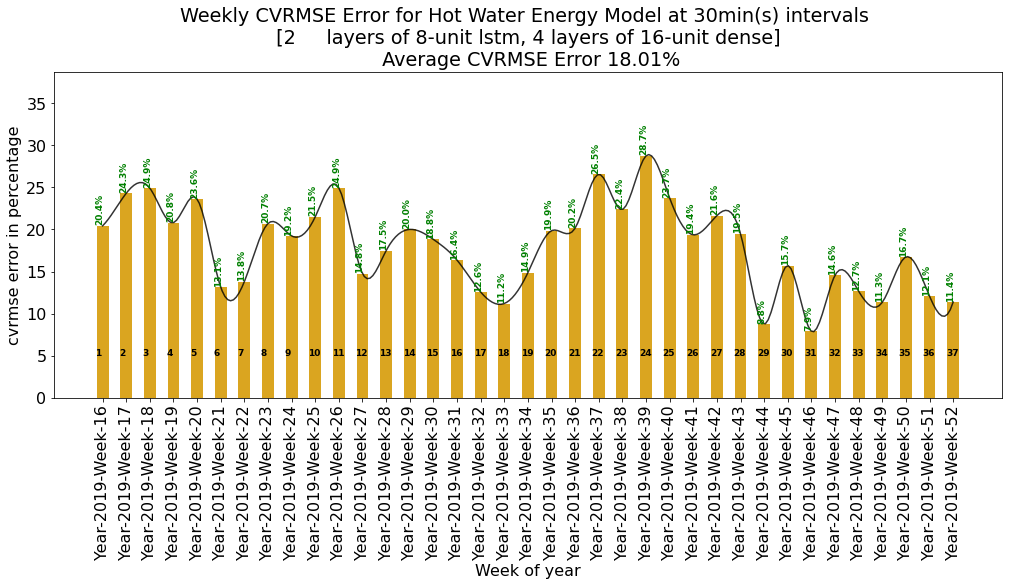

In [25]:
metricname = 'cvrmse'
# Open a file
fo = open(path + "{}min Results_File.txt".format(5 * period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
metric_list = stats['Test'][metricname]

# max_metric = max(cvrmse_list)
# metric_list = [i if i <= 30 else (10*(i-30)/(max_cvrmse-30))+30 for i in cvrmse_list]

cvrmse = sum(metric_list) / len(metric_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=metric_list,
    color='goldenrod',
    bar_label=metricname,
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model at {5:}min(s) intervals \n [{0:} \
    layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse, 5 * period),
    xticklist=xticklist,
    plotwidth=17,
    plotheight=6,
    fontsize=16,
    savetitle=metricname+' plot.png')
pu.regression_bar_plot(**plot_args)

## Merge the pdfs together

In [26]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(glob.glob(os.path.join(pdfs_loc, '*')))

In [27]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
df = pd.read_csv(
    '/data/nauga/SmartBuildings/AlumniHallResearch/AdaptiveController/cdc20/models/adaptive/Trial_0/rl/performance/EnvId1-results.csv',
index_col=0)

In [26]:
df.head()

,rl_cwe,rl_hwe,hist_cwe,hist_hwe,reward_energy,reward_comfort,oat,orh,T_rl_disch,avg_stpt
datetime,,,,,,,,,,
2019-02-21 05:00:00,0.0,0.289705,0.0,0.289705,-0.05,-0.05,0.370336,0.831598,0.663023,0.905318
2019-02-21 05:30:00,0.0,0.293897,0.0,0.293897,-0.05,-0.05,0.362696,0.827967,0.653409,0.905316
2019-02-21 06:00:00,0.0,0.295028,0.0,0.295028,-0.05,-0.05,0.357862,0.829309,0.658838,0.905317
2019-02-21 06:30:00,0.0,0.299833,0.0,0.299833,-0.05,-0.05,0.354021,0.832685,0.652560,0.905320
2019-02-21 07:00:00,0.0,0.306665,0.0,0.306665,-0.05,-0.05,0.349678,0.831965,0.646361,0.905325


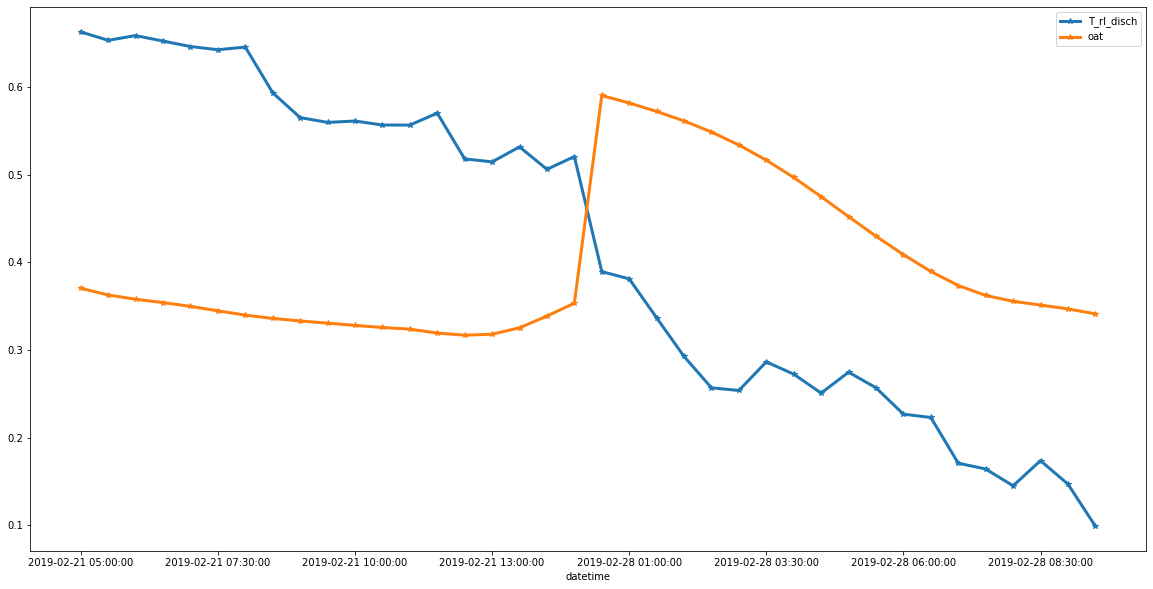

In [29]:
df.plot(y=df.columns[[8,6]],linewidth=3.0,style='*-')